### Connect to Drive

### Import libraries

In [3]:
import tensorflow as tf
import numpy as np
import os
import random


tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2022-11-17 09:27:44.968661: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.10.0


### Set seed for reproducibility

In [47]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Suppress warnings

In [48]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Process data

### Models metadata

In [49]:
input_shape = (96, 96, 3)
batch_size = 32
epochs = 200

### Transfer learning

instead train my network from skratch i train from pre-train network

VGG = supernet

In [50]:
dataset_dir = '/Users/nicolacecere/GitHub/Artificial-Neural-Networks-and-Deep-Learning/SplitData/data'
training_dir = '/Users/nicolacecere/GitHub/Artificial-Neural-Networks-and-Deep-Learning/SplitData/data/training'
validation_dir = '/Users/nicolacecere/GitHub/Artificial-Neural-Networks-and-Deep-Learning/SplitData/data/validation'
test_dir = '/Users/nicolacecere/GitHub/Artificial-Neural-Networks-and-Deep-Learning/SplitData/data/test'

In [51]:
# Images are divided into folders, one for each class.
# If the images are organized in such a way, we can exploit the
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator(rescale=1. / 255, preprocessing_function=preprocess_input)
valid_data_gen = ImageDataGenerator(rescale=1. / 255, preprocessing_function=preprocess_input)
test_data_gen = ImageDataGenerator(rescale=1. / 255, preprocessing_function=preprocess_input)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(96, 96),
                                               color_mode='rgb',
                                               classes=None,  # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed,
                                               )
valid_gen = train_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96, 96),
                                               color_mode='rgb',
                                               classes=None,  # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed,
                                               )
test_gen = train_data_gen.flow_from_directory(directory=test_dir,
                                              target_size=(96, 96),
                                              color_mode='rgb',
                                              classes=None,  # can be set to labels
                                              class_mode='categorical',
                                              batch_size=32,
                                              shuffle=False,
                                              seed=seed,
                                              )

Found 2835 images belonging to 8 classes.
Found 398 images belonging to 8 classes.
Found 495 images belonging to 8 classes.


In [52]:
# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=20,
                                        horizontal_flip= True,
                                        vertical_flip= True,
                                        brightness_range=(0.6,1.4),
                                        zoom_range=0.6,
                                        fill_mode='nearest',
                                        rescale=1./255, # rescale value is multiplied to the image
                                        preprocessing_function=preprocess_input)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=32,
                                                       shuffle=True,
                                                       seed=seed,
                                                       )

Found 2835 images belonging to 8 classes.


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

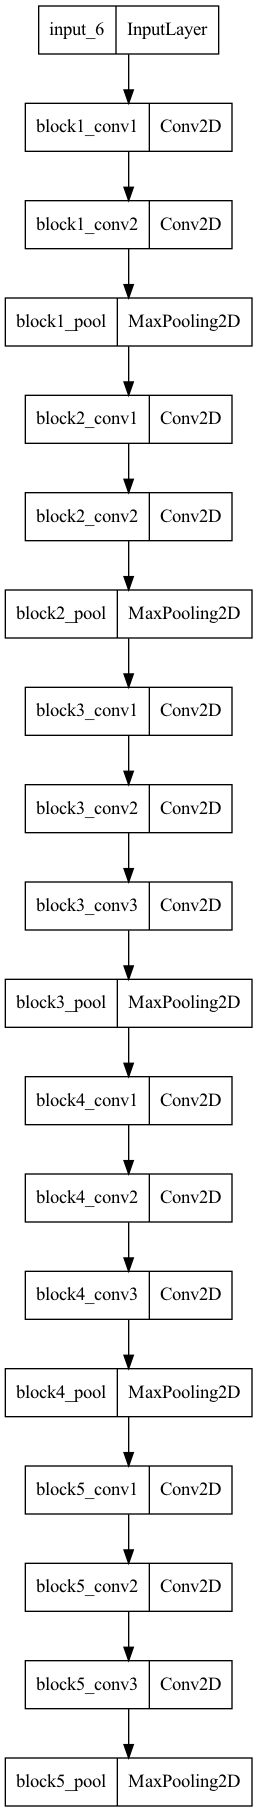

In [53]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [54]:
# Use the supernet as feature extractor
supernet.trainable = False #do not train supernet weights -> in this phase i will update only classifier weights starting from vgg original weights

inputs = tfk.Input(shape=(96,96,3))
x = supernet(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.4, seed=seed)(x)
x = tfkl.Dense(
    512,
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed))(x)
x = tfkl.Dropout(0.4, seed=seed)(x)
outputs = tfkl.Dense(
    8,
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout_6 (Dropout)         (None, 4608)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               2359808   
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 8)                 4104  

In [55]:
# Train the model
tl_history = tl_model.fit(
    x = aug_train_gen,
    batch_size = 32,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/200
72/89 [=======================>......] - ETA: 8s - loss: 2.0781 - accuracy: 0.2567

KeyboardInterrupt: 

In [32]:
# Save the best model
tl_model.save('TransferLearningModel')
del tl_model

In [33]:
model_aug = tfk.models.load_model("TransferLearningModel")
model_aug_test_metrics = model_aug.evaluate(test_gen, return_dict=True)

print()
print("Test metrics with VGG")
print(model_aug_test_metrics)

16/16 [==============================] - 6s 372ms/step - loss: 1.1371 - accuracy: 0.5960

Test metrics with VGG
{'loss': 1.1371444463729858, 'accuracy': 0.5959596037864685}


the blue one is the train with vgg -> faster!!!!

### Fine tuning

In [4]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('TransferLearningModel')
ft_model.summary()

Metal device set to: AMD Radeon Pro 560X


2022-11-17 09:27:57.398475: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 09:27:57.401326: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-17 09:27:57.401473: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 09:27:57.401738: I tensorflow/core/common_runtime/pluggable_device/plug

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout_4 (Dropout)         (None, 4608)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               2359808   
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 8)                 4104  

In [35]:
# Set all VGG layers to True
ft_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_3 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [41]:
# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(ft_model.get_layer('vgg16').layers[:10]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_3 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout_4 (Dropout)         (None, 4608)              0         
  

NameError: name 'ft_model' is not defined

In [37]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

In [38]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = aug_train_gen,
    batch_size = 32,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/200
89/89 [==============================] - 87s 974ms/step - loss: 1.6945 - accuracy: 0.3453 - val_loss: 1.3082 - val_accuracy: 0.5151
Epoch 2/200
89/89 [==============================] - 95s 1s/step - loss: 1.3928 - accuracy: 0.4522 - val_loss: 1.3270 - val_accuracy: 0.5201
Epoch 3/200
89/89 [==============================] - 98s 1s/step - loss: 1.2844 - accuracy: 0.5101 - val_loss: 1.0875 - val_accuracy: 0.5653
Epoch 4/200
89/89 [==============================] - 94s 1s/step - loss: 1.2144 - accuracy: 0.5365 - val_loss: 1.1692 - val_accuracy: 0.5653
Epoch 5/200
89/89 [==============================] - 93s 1s/step - loss: 1.1393 - accuracy: 0.5711 - val_loss: 1.0815 - val_accuracy: 0.5628
Epoch 6/200
89/89 [==============================] - 92s 1s/step - loss: 1.1077 - accuracy: 0.5848 - val_loss: 1.3119 - val_accuracy: 0.4899
Epoch 7/200
89/89 [==============================] - 92s 1s/step - loss: 1.0426 - accuracy: 0.6078 - val_loss: 0.9094 - val_accuracy: 0.6482
Epoch 8/20

In [5]:
ft_model.save('FineTuningModel')
del ft_model

INFO:tensorflow:Assets written to: FineTuningModel/assets


INFO:tensorflow:Assets written to: FineTuningModel/assets


In [40]:
model_aug = tfk.models.load_model("FineTuningModel")
model_aug_test_metrics = model_aug.evaluate(test_gen, return_dict=True)

print()
print("Test metrics with VGG")
print(model_aug_test_metrics)

16/16 [==============================] - 7s 408ms/step - loss: 0.6078 - accuracy: 0.7758

Test metrics with VGG
{'loss': 0.6078025698661804, 'accuracy': 0.7757575511932373}


we should demostrate that we can implement a network from skratch and after use vgg and this things to improve performance but the want see il nostro sviluppo di modello dalle basi per far vedere che abbiamo capito